# Analysis Tutorial

This tutorial demonstrates how to analyze and interpret the outputs from Connectomemapper 3. In particular it will tell you how to:

- Get the list of connectome files with [Pybids](https://pypi.org/project/pybids/)
- Read the .tsv connectome files with [Networkx](https://pypi.org/project/networkx/) and [Pandas](https://pandas.pydata.org/)
- Read the .gpickle files with Networkx
- Read the .mat files with [Scipy](https://scipy.org/)
- Compute the connectome harmonics with [PyGSP](https://pygsp.readthedocs.io/en/stable/index.html)
- Visualize the harmonics with the plot functions of [Nilearn](https://nilearn.github.io/stable/index.html)

If you want to reproduce all the results of this notebook on your side, a conda ``environment.yml`` file can be downloaded at the following link: [``tutorial_environment.yml``](https://github.com/connectomicslab/connectomemapper3/raw/master/notebooks/tutorial_environment.yml). The original ``.ipynb`` notebook file can be downloaded at the following link: [``analysis_tutorial.ipynb``](https://github.com/connectomicslab/connectomemapper3/raw/master/notebooks/analysis_tutorial.ipynb).

Once you have downloaded the conda environment file, install the environment as follows:
```bash
$ conda create env -f /path/to/downloaded/tutorial-env.yml
```
This will install all the packages needed to run this notebook including jupyter lab.

You can then activate it, go to the directory where you downloaded the ``analysis_tutorial.ipynb``, and launch jupyter lab as follows:

```bash
$ cd /directory/of/downloaded/analysis_tutorial.ipynb/
$ conda activate cmp3-tutorial
$ jupyter lab
```

You are ready to open and interact with the notebook!

In [18]:
import nilearn
import os
import sys
import pygsp
import networkx as nx
import pandas as pd
import seaborn as sns
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import datalad.api as dl
import scipy.io as sio
from bids import BIDSLayout
from nilearn import plotting, image, datasets

sys.path.append('../')

## Loading and Plotting Adjacency Matrices

For demonstration, we are going to use the VEPCON dataset, available on [Open Neuro](https://openneuro.org/datasets/ds003505/versions/1.0.2) that already contains output from Connectomemapper. A full description of the dataset can be found in [Pascucci, Tourbier, et al. 2022].

[Pascucci, Tourbier, et al. 2022]: https://doi.org/10.1038/s41597-021-01116-1

In [2]:
# download example dataset with datalad
# uncomment next line once the new dataset is up
#vepcon_data = dl.install(path=os.path.join("..", "..", "example_data"),
#                         source="https://github.com/OpenNeuroDatasets/ds003505.git")

As the dataset is in [BIDS](https://bids.neuroimaging.io/), we can use [Pybids](https://bids-standard.github.io/pybids/) to help us with the task of interacting with the files of the dataset.

In [3]:
#layout = BIDSLayout(vepcon_data.path)
# add derivative folder containing the connectivity matrices
#layout.add_derivatives(os.path.join(vepcon_data.path, "derivatives", "cmp-v3.0.0-beta-RC1"))

In [4]:
#layout = BIDSLayout(vepcon_data.path)
path = os.path.join("/home", "localadmin", "data", "ds003505-sample")
layout = BIDSLayout(path)
# add derivative folder containing the connectivity matrices
#layout.add_derivatives(os.path.join(vepcon_data.path, "derivatives", "cmp-v3.0.0-beta-RC1"))
layout.add_derivatives(os.path.join(path, "derivatives", "cmp-v3.0.1"))

Now we can easily query for the filenames of the files we are interested in using `layout.get`. We will ask for the connectivity matrix of subject 01, scale 3, in tsv format. It will be returned as a list of file paths (in this case containing just one element).

In [5]:
conn_tsv_scale3 = layout.get(subject='01', extension='tsv',
                             suffix='connectivity', return_type='filename',
                             res='scale3')
conn_tsv_scale3

['/home/localadmin/data/ds003505-sample/derivatives/cmp-v3.0.1/sub-01/dwi/sub-01_atlas-L2018_res-scale3_conndata-network_connectivity.tsv']

We can then use [Pandas](https://pandas.pydata.org/) to read the file and display it as a table.

In [6]:
#edges = pd.read_csv(con_files[0], delimiter="\t")
edges = pd.read_csv(conn_tsv_scale3[0], delimiter="\t")
edges.head()

,source,target,number_of_fibers,fiber_length_mean,fiber_length_median,fiber_length_std,fiber_proportion,fiber_density,normalized_fiber_density,FA_mean,FA_std,FA_median,ADC_mean,ADC_std,ADC_median
0,1,1,578,6.577855,6.000000,2.086783,0.139558,0.024422,0.067457,0.190930,0.076994,0.176868,0.000787,0.000086,0.000775
1,1,3,254,9.507873,8.000008,4.339883,0.061328,0.007618,0.021041,0.184138,0.079206,0.172769,0.000801,0.000073,0.000799
2,1,9,101,10.198020,8.500000,4.645918,0.024386,0.003385,0.009351,0.258646,0.100590,0.252733,0.000780,0.000101,0.000756
3,1,2,98,7.704082,6.999998,2.756104,0.023662,0.003056,0.008441,0.247499,0.109299,0.247938,0.000815,0.000060,0.000812
4,1,113,59,10.203390,9.500001,3.235289,0.014245,0.002269,0.006268,0.243196,0.059146,0.241589,0.000858,0.000121,0.000855


Using [Networkx](https://networkx.org/documentation/stable/index.html), we can convert this table to a network graph. From that, we can convert individual measures to a [Numpy](https://numpy.org/) array. The array format is especially useful, as it allows us to plot the edge weights easily.

In [7]:
G = nx.from_pandas_edgelist(edges, edge_attr=True)
A_fiber_density = nx.to_numpy_array(G, weight="fiber_density")

Let's plot some of those adjacency matrices using [Matplotlib](https://matplotlib.org/) and [Seaborn](http://seaborn.pydata.org/index.html):

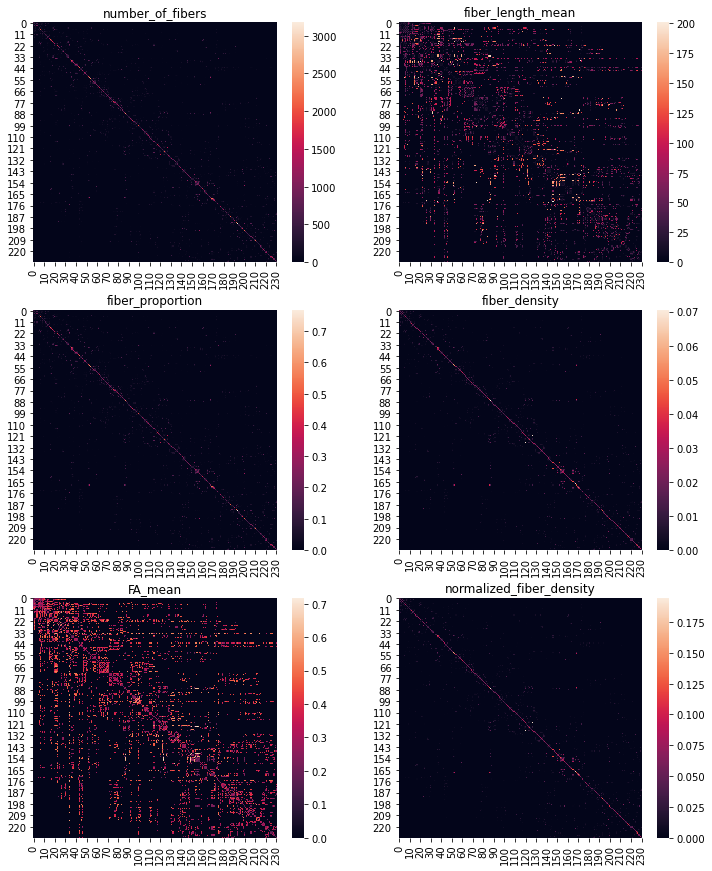

In [8]:
cols_to_plot = ["number_of_fibers", "fiber_length_mean",
                "fiber_proportion", "fiber_density",
                "FA_mean", "normalized_fiber_density"]

fig, axs = plt.subplots(3,2, figsize=(12,15))
axs = axs.flatten()
for c, ax in zip(cols_to_plot, axs):
    A = nx.to_numpy_array(G, weight=c)
    sns.heatmap(A, ax=ax)
    ax.set_title(c)

Alternatively, we can also load the matrices in network format, by reading the gpickle files using Networkx:

In [9]:
conn_gpickle_scale3 = layout.get(subject='01', extension='gpickle',
                                 suffix='connectivity',
                                 return_type='filename',
                                 res='scale3')
G = nx.read_gpickle(conn_gpickle_scale3[0])  # same format as with tsv

...or load the .mat files with [Scipy](https://scipy.org/):

In [10]:
conn_mat_scale3 = layout.get(subject='01', extension='mat',
                             suffix='connectivity', return_type='filename',
                             res='scale3')
A_mat = sio.loadmat(conn_mat_scale3[0])

The adjacency matrices here can be accessed like this:

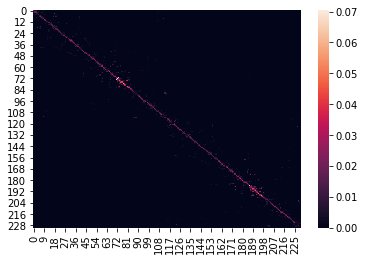

In [11]:
sns.heatmap(A_mat["sc"]["fiber_density"][0][0])
plt.show()

## Graph Signal Processing with Structural Connectivity

The package [PyGSP](https://pygsp.readthedocs.io/en/stable/index.html) offers a range of graph signal processing tools we can use on our structural connectivity data. In particular, we can do an eigendecomposition of the [graph Laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix) to get the Fourier basis - the connectome harmonics.

Even though it is possible to also do this for subcortical regions, for the sake of plotting it is easier just to work with the cortical regions. To identify those, we need the parcellation labels.

In [12]:
# UPDATE PATH ONCE AVAILABLE
anat_folder = "/home/localadmin/data/ds003505-sample/derivatives/cmp-v3.0.1/sub-01/anat"
# read label tsv file
label_path = os.path.join(anat_folder, "sub-01_atlas-L2018_res-scale3_dseg.tsv")
labels = pd.read_csv(label_path, sep="\t", index_col=0)
# reset index to start at 0
labels.reset_index(inplace=True)
# select cortex labels
labels_ctx = labels["name"][[n.startswith("ctx") for n in labels["name"]]].copy()
idx = list(labels_ctx.index)
# select rows with cortical areas
#A_fd_ctx = A_fiber_density[idx]
A = nx.to_numpy_array(G, weight="FA_mean")
A_fd_ctx = A[idx]
# select columns with cortical areas
A_fd_ctx = A_fd_ctx[:,idx]

In [13]:
A_fd_ctx.shape

(216, 216)

Now we can compute the harmonics:

In [14]:
np.fill_diagonal(A_fd_ctx, 0)  # PyGSP does not support self-loops
G_fd = pygsp.graphs.Graph(A_fd_ctx)  # PyGSP graph
G_fd.compute_laplacian(lap_type="normalized")
G_fd.compute_fourier_basis()  # compute connectome harmonics

The harmonics have the same dimensions as our original adjacency matrix.

In [15]:
G_fd.U.shape

(216, 216)

Each column contains one basis vector.

### Basic visualization with ``Nilearn``

[Nilearn](https://nilearn.github.io/stable/index.html) offers a quick and easy way to plot them using `plot_markers`. For this, we need the center coordinates of each region in the parcellation in MNI space. For your convenience, they have been already computed and can be easily retrieved with the `get_lausanne2018_parcellation_mni_coords(scale)` utility function of CMP3.

In [19]:
from cmtklib.data.parcellation.util import get_lausanne2018_parcellation_mni_coords

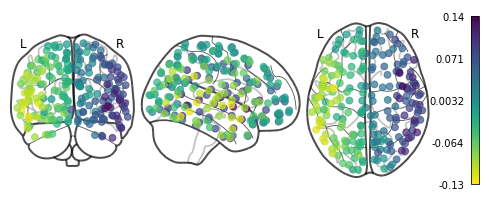

In [20]:
# load coordinates with the utility function provided by CMP3
coords_ctx = get_lausanne2018_parcellation_mni_coords('scale3')
# plot
plotting.plot_markers(G_fd.U[:,1], coords_ctx)

### Advanced visualization with ``Nilearn``

A prettier version is to plot the connectome harmonics on a brain surface using Nilearn `plot_surf_roi()`. For this task, you will need the Freesurfer `.annot` files of the Lausanne 2018 parcellation. For your convenience, they can be easily retrieved with the `get_lausanne2018_parcellation_annot(scale,hemi)` utility function of CMP3. These figures take a few minutes to generate, so you might need to be a bit patient.

In [21]:
from cmtklib.data.parcellation.util import get_lausanne2018_parcellation_annot

In [42]:
def plot_surface_ctx(
    roi_values, scale='scale1', cmap="Spectral", save_fig=False,
    output_dir="./", filename=None, fmt="png"):
    """
    Plots a set of values on a cortex surface on a given scale of the Lausanne 2018 parcellation.
    
    Parameters
    ----------
    roi_values: numpy array
        The values to be plotted on the surface. The array should
        have as many values as regions of interest

    scale: {'scale1', 'scale2', 'scale3', 'scale4', 'scale5'}
        Scale of the Lausanne 2018 atlas to be used

    cmap: string
        Colormap to use for plotting, default "Spectral"

    save_fig: bool
        Whether to save the generated figures, default: `False`

    output_dir: string
        Directory to save the figure, only used when
        `save_fig == True`

    filename: string
        Filename of the saved figure (without the extension),
        only used when `save_fig == True`

    fmt: string
        Format to save the figures in
        Default: "png", also
        accepted are "pdf", and "svg" (and others, depending
        on the backend used)

    """
    # Surface mesh
    fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage")

    # File paths to the annot files
    annots = [get_lausanne2018_parcellation_annot(scale=f'{scale}', hemi='rh'),
              get_lausanne2018_parcellation_annot(scale=f'{scale}', hemi='lh')]

    # Read annot files
    annot_right = nb.freesurfer.read_annot(annots[0])
    annot_left = nb.freesurfer.read_annot(annots[1])

    # Create vector to store intensity values (one value per vertex)
    roi_vect_right = np.zeros_like(annot_right[0], dtype=float)
    roi_vect_left = np.zeros_like(annot_left[0], dtype=float)

    # Convert labels to strings, labels are the same as 2018 is symmetric
    labels = [str(elem, 'utf-8') for elem in annot_right[2]]

    # Create roi vectors
    for i in range(len(labels[1:])):  # skip 'unknown'
        ids_roi = np.where(annot_right[0] == i+1)[0]
        roi_vect_right[ids_roi] = roi_values[i]

    for i in range(len(labels[1:])):  # skip 'unknown'
        ids_roi = np.where(annot_left[0] == i+1)[0]
        roi_vect_left[ids_roi] = roi_values[i+len(labels)-1]

    # Get min and max values
    vmin = min(roi_values)
    vmax = max(roi_values)

    # Center around 0
    max_val = max([abs(vmin), vmax])
    vmax = max_val
    vmin = -max_val
    
    # Creation of list to allow iteration
    # and reduce duplication of plotting.plot_surf_roi()
    hemis = [
        'right', 'left', 'right', 'left',
        'right', 'left', 'right', 'left',
    ]
    views = [
        'lateral', 'lateral', 'medial', 'medial',
        'ventral', 'ventral', 'dorsal', 'dorsal'
    ]
    surfaces = [f'pial_{hemi}' for hemi in hemis]
    bg_maps = [f'sulc_{hemi}' for hemi in hemis]
    roi_vectors = [roi_vect_right, roi_vect_left]*4

    # Initial a figure with [2 x 4] subplots
    fig, axs = plt.subplots(nrows=2, ncols=4,
                            subplot_kw={'projection': '3d'},
                            figsize=(20,10))
    axs = axs.flatten()

    # Iterate over the list of views to render
    for i, (hemi, surf, bg_map, view, vector, ax) in enumerate(
        zip(hemis, surfaces, bg_maps, views, roi_vectors, axs)
    ):
        plotting.plot_surf_roi(fsaverage[f'{surf}'], roi_map=vector,
                               hemi=hemi, view=view,
                               bg_map=fsaverage[f'{bg_map}'], bg_on_data=True,
                               darkness=.5,
                               cmap=cmap, vmin=vmin, vmax=vmax,
                               axes=axs[i])

    # Save the figure in the desired format if enabled
    if save_fig:
        if filename is None:
            filename = f'atlas-{scale}_projection'
        fig.savefig(f'{output_dir}/{filename}.{fmt}')

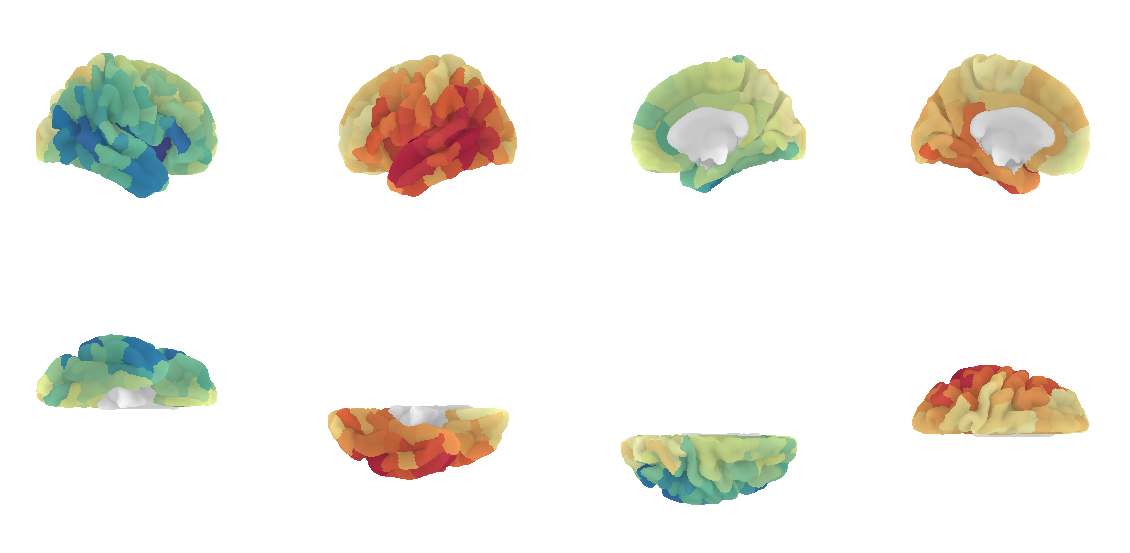

In [43]:
plot_surface_ctx(G_fd.U[:,1], scale='scale3')

Pretty, right? This concludes the tutorial.

## Want to learn more about connectome harmonics?

Here are some references:

- Human brain networks function in connectome-specific harmonic waves (Atasoy et al., 2016, [link](https://www.nature.com/articles/ncomms10340)): Landmark paper that first applied graph signal processing to brain connectivity.

- Functional harmonics reveal multi-dimensional basis functions underlying cortical organization (Glomb et al., 2021, [link](https://doi.org/10.1016/j.celrep.2021.109554)): Connectome harmonics of functional connectivity.

- The connectome spectrum as a canonical basis for a sparse representation of fast brain activity (Rué-Queralt et al., 2021, [link](10.1016/j.neuroimage.2021.118611)): EEG and connectome harmonics.